In [155]:
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.metrics import pairwise
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [156]:
data_path = "../data/neurips-2023-data/de_per_donor.h5ad"

In [157]:
adata = ad.read_h5ad(data_path)

In [158]:
threshold_0001 = -np.log10(0.0001)

In [159]:
# create another layer with adj.P.Value thresholded
adata.layers['sign_log10_pval_clipped_0001'] = np.clip(adata.layers['sign_log10_pval'], -threshold_0001, threshold_0001)

In [160]:
for w1, w2 in [(0.1, 0.9)]:
    weighted_sum = (w1 * np.abs(adata.layers['logFC'])) + (w2 * adata.layers['sign_log10_pval'])
    adata.layers[f'weighted_sum_{w1}_{w2}'] = weighted_sum

In [161]:
def de_to_t_score(de):
    """Convert log10pvalues to t-scores
    
    Parameter:
    de: array or DataFrame of log10pvalues
    
    Return value:
    t_score: array or DataFrame of t-scores
    """
    p_value = 10 ** (-np.abs(de))
    return - norm.ppf(p_value / 2) * np.sign(de)

In [162]:
adata.layers['t_score'] = de_to_t_score(adata.layers['sign_log10_pval'])

In [163]:
ranks = {
    'signature': [],
    'cell_type': [],
    'donor_id_1': [],
    'donor_id_2': [],
    'sm_name': [],
    'rank': [],
}

# Iterate over each layer (signature) to calculate cosine similarities
for signature in adata.layers.keys():
    print(f"Processing signature: {signature}")
    for cell_type in adata.obs['cell_type'].unique():
        # Filter data by sm_cell_type
        cell_type_adata = adata[adata.obs['cell_type'] == cell_type]
        sm_names = cell_type_adata.obs['sm_name'].unique()

        # Get unique donors within this sm_cell_type
        donors = cell_type_adata.obs['donor_id'].unique()

        # Iterate over all combinations of two different donors
        for donor_id_1, donor_id_2 in itertools.combinations(donors, 2):
            # Filter data for each donor
            donor_data_1 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_1]
            donor_data_2 = cell_type_adata[cell_type_adata.obs['donor_id'] == donor_id_2]
            
            for sm_name in donor_data_1.obs['sm_name'].unique():
                if sm_name not in donor_data_2.obs['sm_name'].unique():
                    continue
                # get index of sm_name in donor_data_2
                idx = np.where(donor_data_2.obs['sm_name'] == sm_name)[0][0]
                cosine_similarity = pairwise.cosine_similarity(
                    donor_data_1[donor_data_1.obs['sm_name'] == sm_name].layers[signature],
                    donor_data_2.layers[signature]
                )
                rank = np.where(np.argsort(-cosine_similarity) == idx)[1][0]
                ranks['signature'].append(signature)
                ranks['cell_type'].append(cell_type)
                ranks['donor_id_1'].append(donor_id_1)
                ranks['donor_id_2'].append(donor_id_2)
                ranks['sm_name'].append(sm_name)
                ranks['rank'].append(rank)

# Convert ranks to DataFrame for easier manipulation and output
ranks_df = pd.DataFrame(ranks)

Processing signature: P.Value
Processing signature: adj.P.Value
Processing signature: is_de
Processing signature: is_de_adj
Processing signature: logFC
Processing signature: sign_log10_nonadj_pval
Processing signature: sign_log10_pval
Processing signature: sign_log10_pval_clipped_0001
Processing signature: weighted_sum_0.1_0.9
Processing signature: t_score


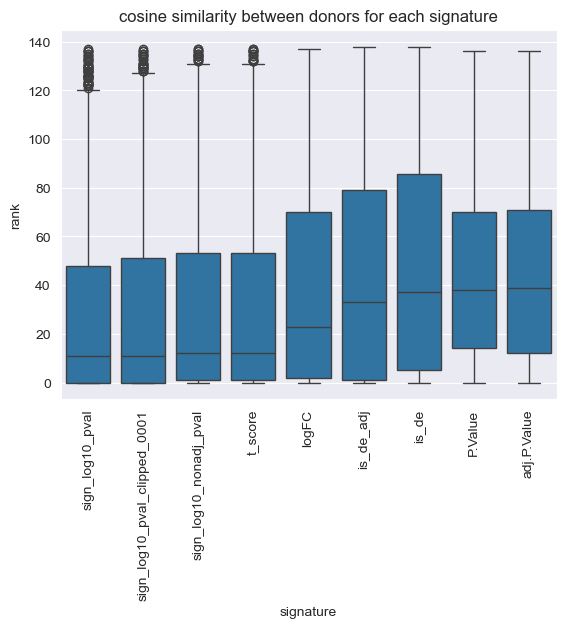

In [175]:
ranks_df_subset = ranks_df[~ranks_df.signature.isin(["weighted_sum_0.1_0.9"])]
ordered_signatures = ranks_df_subset.groupby('signature')['rank'].median().sort_values().index
sns.boxplot(data=ranks_df_subset, x='signature', y='rank', order=ordered_signatures)
plt.xticks(rotation=90)
plt.title('cosine similarity between donors for each signature')
plt.show()

In [176]:
# we see that signature 'sign_log10_pval' has the lowest rank, closely followed by non-adjusted sign_log10_pval and logFC.
# we skip the weighted_sum_0.1_0.9 which performs even a bit better, since we believe it requires further validation to be shown to be more than by chance
# We analyze these three signatures further

In [179]:
ranks_df_subset = ranks_df[ranks_df['signature'].isin(['sign_log10_pval', 't_score', 'logFC', 'sign_log10_nonadj_pval', "sign_log10_pval_clipped_0001"])]

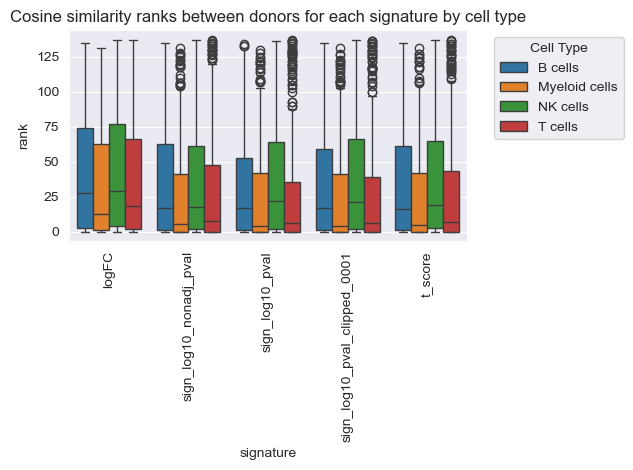

In [180]:
# same but per cell type, donor and sm_name
sns.boxplot(data=ranks_df_subset, x='signature', y='rank', hue='cell_type')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.title('Cosine similarity ranks between donors for each signature by cell type')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside of the plot
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [181]:
# we note that the representations appear to capture T cells and Myeloid cells best. B cells and NK cells are less consistent
# we focus on sign_log10_pval

In [188]:
ranks_df_subset = ranks_df[ranks_df['signature'].isin(['sign_log10_pval_clipped_0001'])].copy()

In [189]:
ordered_signatures = ranks_df_subset.groupby('sm_name')['rank'].median().sort_values().index

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


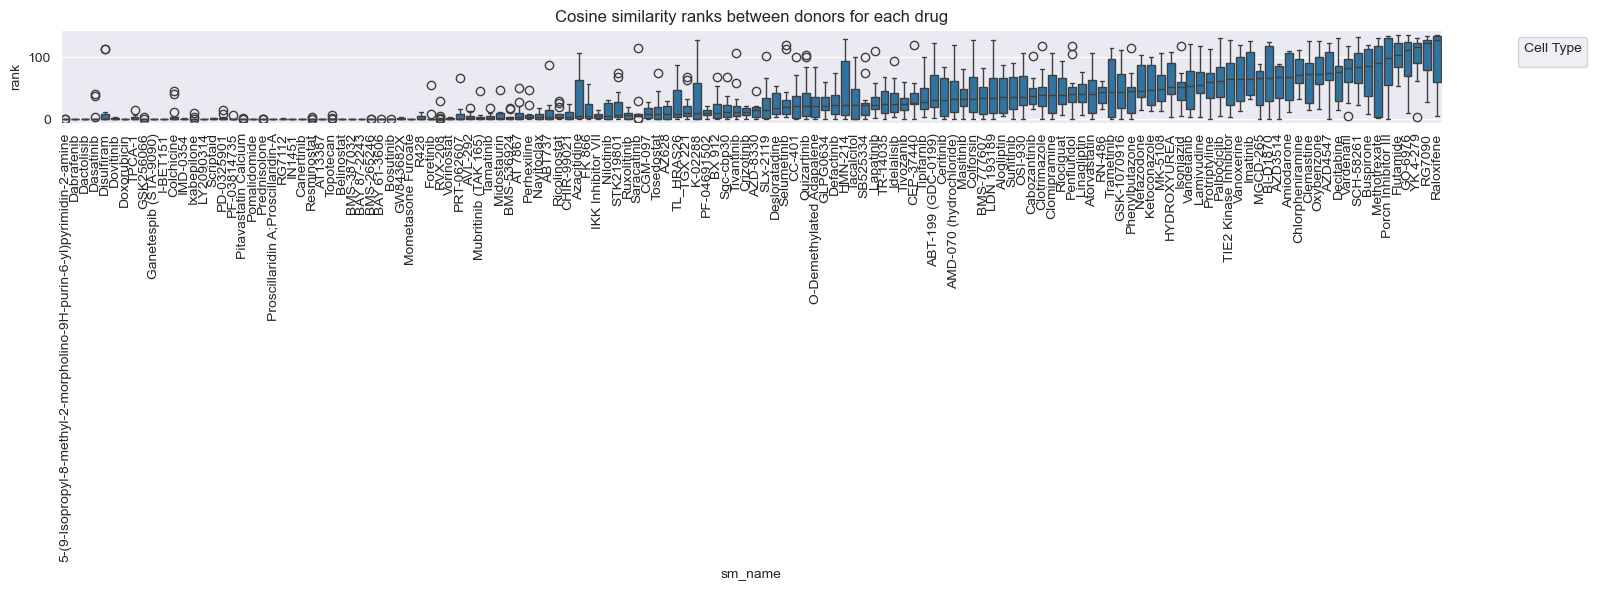

In [190]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=ranks_df_subset, x='sm_name', y='rank', order=ordered_signatures)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.title('Cosine similarity ranks between donors for each drug')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside of the plot
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [191]:
adata_df = pd.DataFrame(adata.layers['adj.P.Value'], columns=adata.var_names)
adata_df['sm_name'] = adata.obs['sm_name'].values  # Add 'sm_name' from .obs to the DataFrame

# Step 2: Group by 'sm_name' and sum the 'sign_log10_pval'
grouped_sum = adata_df.groupby('sm_name').mean()

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_4694/2862755947.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sum = adata_df.groupby('sm_name').mean()


In [192]:
sum_sign_log10_pval = grouped_sum.mean(axis=1)
sm_name_to_sum_pval = sum_sign_log10_pval.to_dict()

In [193]:
ranks_df_subset["sum_pval"] = ranks_df_subset["sm_name"].map(lambda x: sm_name_to_sum_pval[x])

In [194]:
ranks_df_subset["median_rank"] = ranks_df_subset["sm_name"].map(ranks_df_subset.groupby('sm_name')['rank'].median().to_dict())

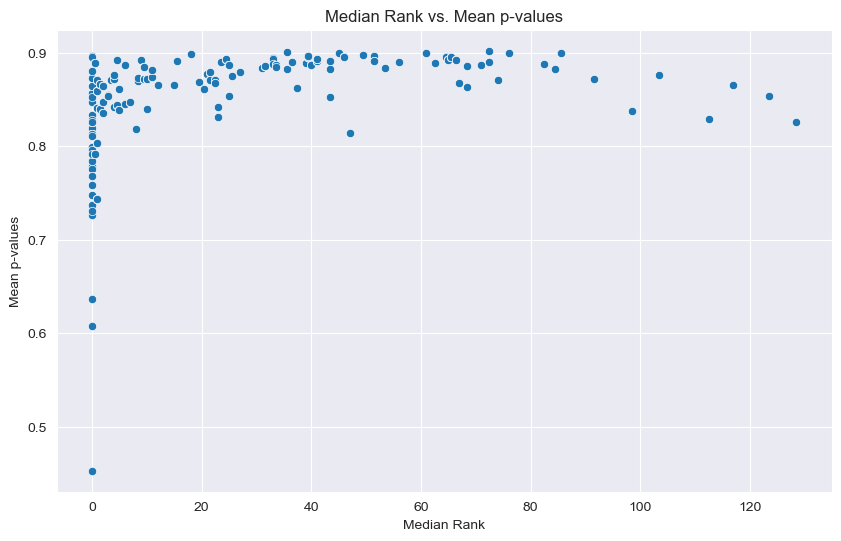

In [195]:
df_sorted = ranks_df_subset.sort_values('median_rank')

# Step 2: Create the plot using seaborn
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
ax = sns.scatterplot(data=df_sorted, x='median_rank', y='sum_pval')

# Optional: Customize the plot
plt.title('Median Rank vs. Mean p-values')
plt.xlabel('Median Rank')
plt.ylabel('Mean p-values')
# ax.set_xscale('log')
# ax.set_yscale('log')

# Show the plot
plt.show()

In [196]:
df_sorted[df_sorted.sum_pval < 0.8].sm_name.unique()

array(['Proscillaridin A;Proscillaridin-A', 'Pitavastatin Calcium',
       'Resminostat', 'Doxorubicin', 'Colchicine', 'Scriptaid',
       'BAY 61-3606', 'LY2090314', 'IN1451', 'I-BET151', 'Belinostat',
       'Dactolisib', 'Dabrafenib', 'Ganetespib (STA-9090)', 'IMD-0354',
       'AT13387', 'Mometasone Furoate', 'Vorinostat'], dtype=object)

In [198]:
# molecules with low p-values and poor retrieval
ranks_df_subset[(ranks_df_subset['median_rank'] > 80) & (ranks_df_subset['sum_pval'] > 100)].sm_name.unique()

array([], dtype=object)

In [138]:
# the only molecule that downregulates many genes
ranks_df_subset[ranks_df_subset['sum_pval'] < -1].sm_name.unique()

array([], dtype=object)

In [139]:
# group molecules by signature

In [146]:
de_train_path = "../data/neurips-2023-data/de_train.h5ad"
de_test_path = "../data/neurips-2023-data/de_test.h5ad"

In [147]:
adata_train = ad.read_h5ad(de_train_path)
adata_test = ad.read_h5ad(de_test_path)

In [151]:
import scanpy as sc

In [152]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [161]:
moa_annotations = pd.read_csv("../data/complete_data/moa_annotations.csv")

In [162]:
adata_train.obs["moa_annotations"] = adata_train.obs["sm_name"].map(moa_annotations.set_index("sm_name")["moa"])

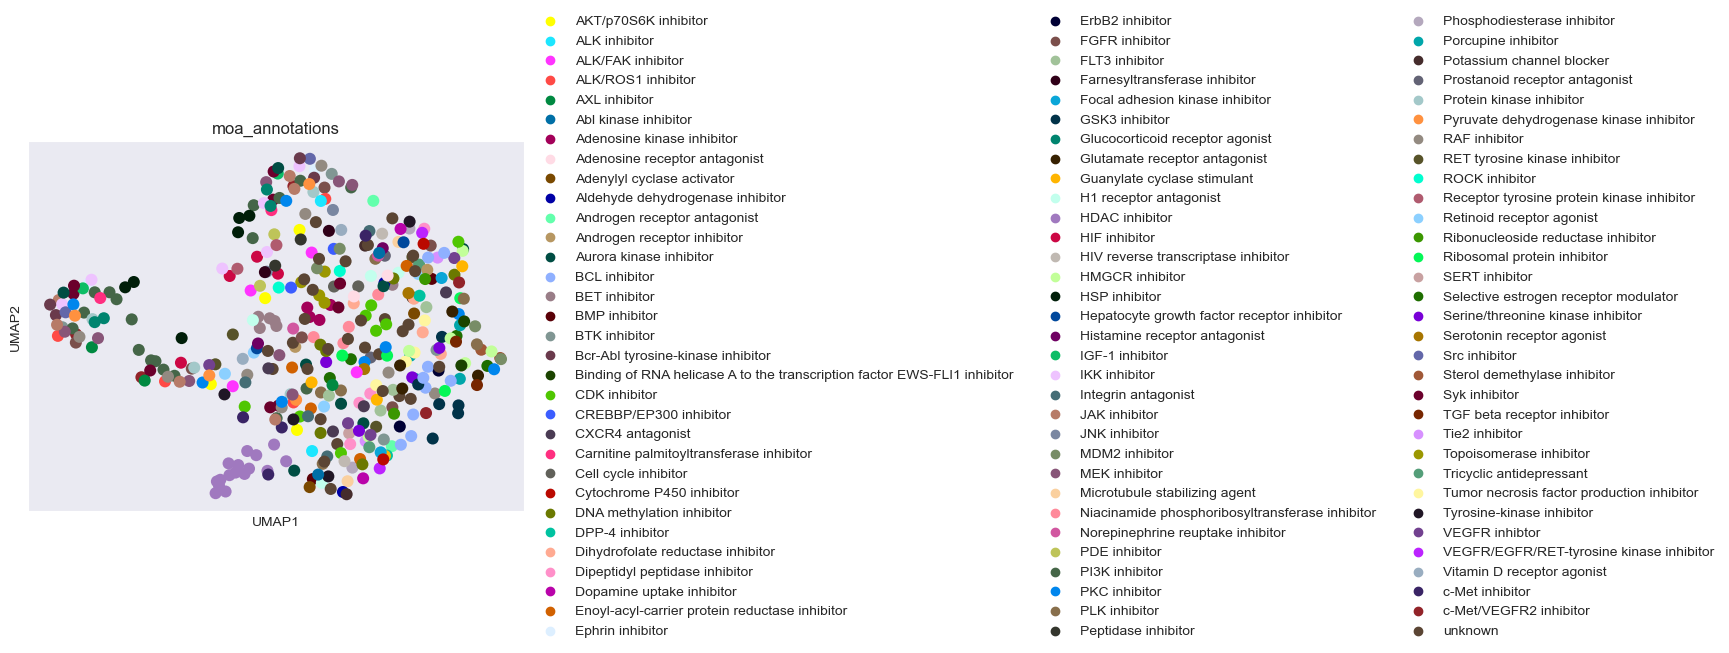

In [170]:
sc.pl.umap(adata_train, color="moa_annotations")

In [168]:
sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test)

         Falling back to preprocessing with `sc.pp.pca` and default params.


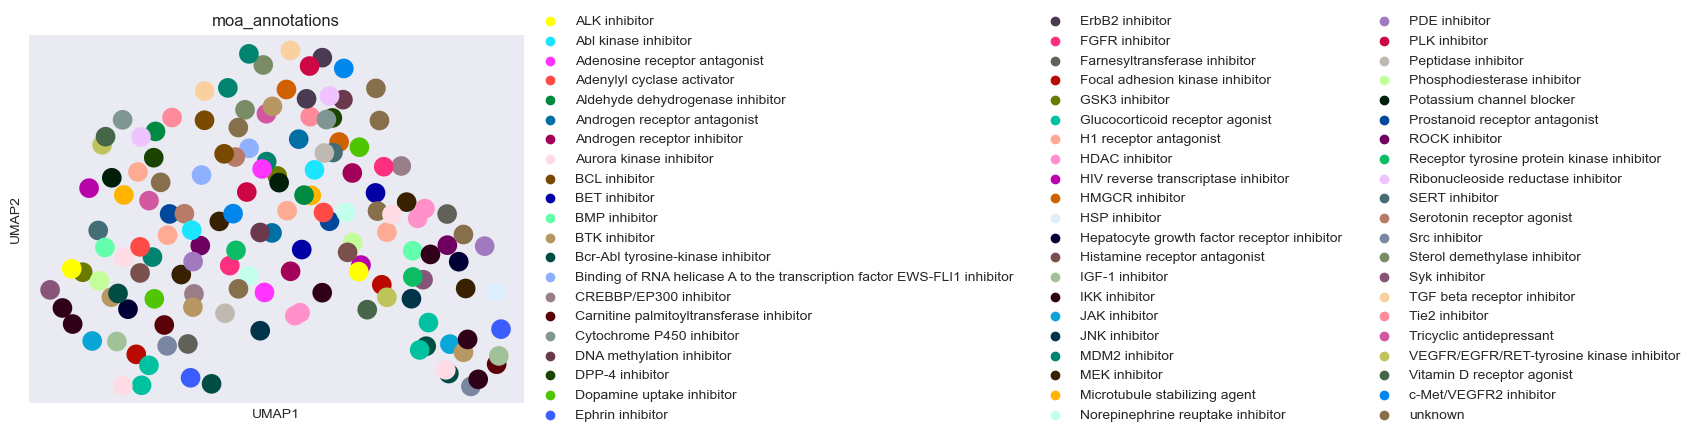

In [171]:
adata_test.obs["moa_annotations"] = adata_test.obs["sm_name"].map(moa_annotations.set_index("sm_name")["moa"])
sc.pl.umap(adata_test, color="moa_annotations")

In [203]:
adata_new = ad.read_h5ad("../data/neurips-2023-data/de_train.h5ad")

In [204]:
pseudobulk_new = ad.read_h5ad("../data/neurips-2023-data/pseudobulk_cleaned.h5ad")

In [205]:
pseudobulk_new = pseudobulk_new[(pseudobulk_new.obs.split == "train") | (pseudobulk_new.obs.split == "control")]

In [206]:
zero_genes = {}
pseudobulk_dmso = pseudobulk_new[pseudobulk_new.obs.sm_name == 'Dimethyl Sulfoxide']
for cell_type in pseudobulk_dmso.obs.cell_type.unique():
    zero_genes[cell_type] = pseudobulk_dmso[:, pseudobulk_dmso[pseudobulk_dmso.obs.cell_type == cell_type].X.sum(axis=0) == 0].var_names.tolist()

In [207]:
len(zero_genes)

4

In [181]:
# illustrate the issue of low p-values despite no change in counts
kaggle_path = "../data/neurips-2023-kaggle/2023-09-12_de_by_cell_type_train.h5ad"
adata_kaggle = ad.read_h5ad(kaggle_path)

In [182]:
pseudobulk = ad.read_h5ad("../data/neurips-2023-kaggle/pseudobulk.h5ad")

In [183]:
pseudobulk = pseudobulk[(pseudobulk.obs.split == "train") | (pseudobulk.obs.split == "control")]

In [184]:
pseudobulk = pseudobulk[:, adata_kaggle.var_names]

In [185]:
pseudobulk.obs["sm_celltype"] = pseudobulk.obs["sm_name"].astype(str) + pseudobulk.obs["cell_type"].astype(str)
pseudobulk.obs["sm_celltype"] = pseudobulk.obs["sm_celltype"].astype("category")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_10139/162728329.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pseudobulk.obs["sm_celltype"] = pseudobulk.obs["sm_name"].astype(str) + pseudobulk.obs["cell_type"].astype(str)


In [198]:
# find zero celltype-gene combinations
zero_genes = {}

In [199]:
pseudobulk_dmso = pseudobulk[pseudobulk.obs.sm_name == 'Dimethyl Sulfoxide']

In [200]:
for cell_type in pseudobulk_dmso.obs.cell_type.unique():
    zero_genes[cell_type] = pseudobulk_dmso[:, pseudobulk_dmso[pseudobulk_dmso.obs.cell_type == cell_type].X.sum(axis=0) == 0].var_names.tolist()

In [201]:
len(zero_genes)

6

In [189]:
zero_genes_other = {}

In [ ]:
for sm_celltype in pseudobulk.obs.sm_celltype.unique():
    cur_adata = pseudobulk[pseudobulk.obs.sm_celltype == sm_celltype]
    cur_celltype = cur_adata.obs.cell_type.values[0]
    zero_genes_dmso = zero_genes[cur_celltype]
    zero_genes_cur = cur_adata[:, cur_adata.X == 0].var_names.tolist()
    zero_genes_cur = set(zero_genes_cur).intersection(zero_genes_dmso)
    if len(zero_genes_cur) > 0:
        zero_genes_other[sm_celltype] = zero_genes_cur

In [193]:
len(zero_genes_other)

620

In [191]:
# there are 620 drug-cell type combindations that have zero counts in both, the drug and the control

In [192]:
adata_kaggle.obs["sm_celltype"] = adata_kaggle.obs["sm_name"].astype(str) + adata_kaggle.obs["cell_type"].astype(str)
adata_kaggle.obs["sm_celltype"] = adata_kaggle.obs["sm_celltype"].astype("category")

In [155]:
small_pvals = {}

In [156]:
for sm_celltype in zero_genes_other.keys():
    if sm_celltype not in adata_kaggle.obs.sm_celltype.unique():
        continue
    # check p-values
    cur_adata = adata_kaggle[adata_kaggle.obs.sm_celltype == sm_celltype, list(zero_genes_other[sm_celltype])]
    cur_pvals = cur_adata.layers["P.Value"]
    genes_with_small_pvals = cur_adata[:, cur_pvals < 0.05].var_names
    if len(genes_with_small_pvals) > 0:
        small_pvals[sm_celltype] = genes_with_small_pvals

In [157]:
len(small_pvals)

145

In [158]:
# calculate the number of genes with small p-values
total_small_pvals = 0
for sm_celltype in small_pvals.keys():
    total_small_pvals += len(small_pvals[sm_celltype])

In [159]:
total_small_pvals

99713

In [109]:
ranks_df.to_csv("../data/cross_donor_retrieval_ranks_df.csv")